In [1]:
import numpy as np
import pandas as pd

# matplotlib and seaborn for plotting
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120 #resolution
matplotlib.rcParams['figure.figsize'] = (8,6) #figure size

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
color = sns.color_palette()

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.decomposition import PCA

In [2]:
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')
orders = pd.read_csv('orders.csv')
order_products_prior = pd.read_csv('order_products__prior.csv')
order_products_train = pd.read_csv('order_products__train.csv')
products = pd.read_csv('products.csv')

### For segmentation I am considering users from prior set only

In [3]:
order_products = order_products_prior.merge(products, on ='product_id', how='left')
order_products = order_products.merge(aisles, on ='aisle_id', how='left')
order_products = order_products.merge(departments, on ='department_id', how='left')
order_products = order_products.merge(orders, on='order_id', how='left')
order_products.shape

(32434489, 15)

In [4]:
order_products

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32434484,3421083,39678,6,1,Free & Clear Natural Dishwasher Detergent,74,17,dish detergents,household,25247,prior,24,2,6,21.0
32434485,3421083,11352,7,0,Organic Mini Sandwich Crackers Peanut Butter,78,19,crackers,snacks,25247,prior,24,2,6,21.0
32434486,3421083,4600,8,0,All Natural French Toast Sticks,52,1,frozen breakfast,frozen,25247,prior,24,2,6,21.0
32434487,3421083,24852,9,1,Banana,24,4,fresh fruits,produce,25247,prior,24,2,6,21.0


In [5]:
order_products.user_id.nunique()

206209

## Segmentation

Since there are thousands of products in the dataset I will rely on aisles, which represent categories of products. Even with aisles features will be too much so I will use Principal Component Analysis to find new dimensions along which clustering will be easier.

In [6]:
cross_df = pd.crosstab(order_products.user_id, order_products.aisle)
cross_df.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,0,3,0,0,0,0,2,0,0,0,...,3,1,1,0,0,0,0,2,0,42
3,0,0,0,0,0,0,0,0,0,0,...,4,1,0,0,0,0,0,2,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
5,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [9]:
cross_df.tail()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
206205,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
206206,0,4,0,0,0,0,4,1,0,0,...,1,0,0,0,0,1,0,1,0,0
206207,0,0,0,0,1,0,0,0,0,0,...,3,4,0,2,1,0,0,11,0,15
206208,0,3,0,0,3,0,4,0,0,0,...,5,0,0,7,0,0,0,0,0,33
206209,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,3


In [9]:
cross_df.shape

(206209, 134)

I will normalize each row

In [10]:
df = cross_df.div(cross_df.sum(axis=1), axis=0)
df.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.016949,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.016949
2,0.0,0.015385,0.0,0.0,0.0,0.0,0.010256,0.0,0.0,0.0,...,0.015385,0.005128,0.005128,0.000000,0.0,0.0,0.0,0.010256,0.0,0.215385
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.045455,0.011364,0.000000,0.000000,0.0,0.0,0.0,0.022727,0.0,0.000000
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.055556,0.0,0.0,0.0,0.055556,0.0,0.000000
5,0.0,0.054054,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.081081


In [11]:
df.shape

(206209, 134)

### PCA and K-Means Clustering
We can then execute a Principal Component Analysis to the obtained dataframe. This will reduce the number of features from the number of aisles to 10, the numbr of principal components I have chosen.

In [12]:
pca = PCA(n_components=10)
df_pca = pca.fit_transform(df)
df_pca = pd.DataFrame(df_pca)
df_pca.head()

,0,1,2,3,4,5,6,7,8,9
0,-0.113443,0.039084,-0.042863,0.018865,-0.088334,-0.104526,-0.116459,0.083732,-0.061923,-0.025702
1,-0.036988,0.108884,-0.066406,-0.123271,0.098849,-0.033957,-0.054735,-0.053378,-0.020547,-0.008099
2,0.064282,0.103962,0.000710,-0.012222,-0.046982,0.112251,-0.029833,0.007838,0.012258,0.001874
3,-0.093210,0.054093,0.001867,-0.003973,-0.071360,-0.019295,-0.025082,-0.038225,0.006126,-0.000852
4,0.094629,-0.037051,-0.024952,-0.021575,0.055370,0.107646,-0.008041,0.103931,0.051640,-0.025748


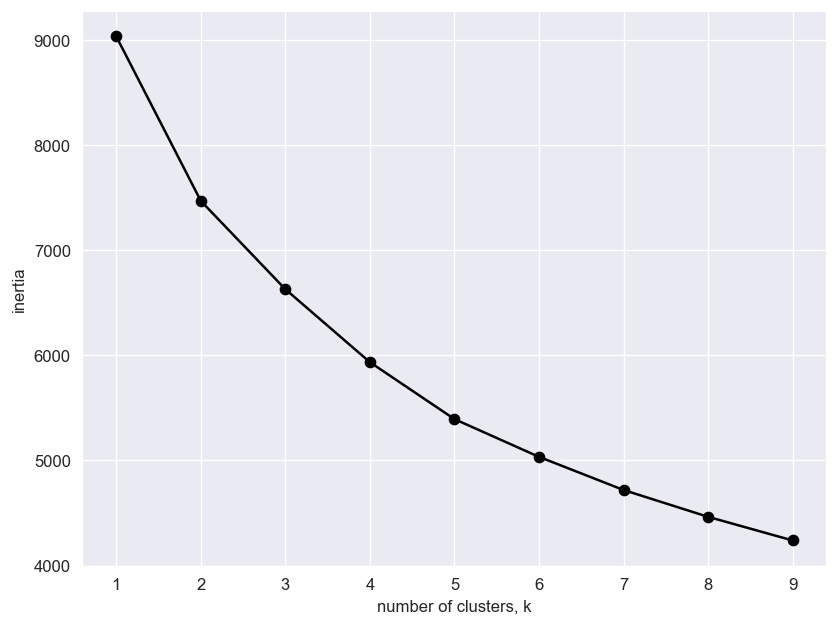

In [13]:
#Implementing the Elbow method to identify the ideal value of 'k'. 

import warnings
warnings.filterwarnings('ignore')

ks = range(1,10) #hit and trial, let's try it 10 times.
inertias = []
for k in ks:
    model = KMeans(n_clusters=k)    # Create a KMeans instance with k clusters: model
    model.fit(df_pca)                    # Fit model to samples
    inertias.append(model.inertia_) # Append the inertia to the list of inertias
    
plt.plot(ks, inertias, '-o', color='black') #Plotting. The plot will give the 'elbow'.
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [14]:
clusterer = KMeans(n_clusters=5,random_state=42).fit(df_pca)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(df_pca)
print(centers)

[[ 1.05520457e-01 -7.30445665e-02  1.72393223e-02  3.66409532e-03
   1.76775669e-03 -4.42270448e-03 -9.46583417e-04  1.29775213e-03
  -1.66154395e-04  7.76463886e-04]
 [-7.38761088e-02 -1.05594754e-02 -2.70218186e-02 -7.01396943e-03
  -6.74409941e-03  1.55267911e-03  5.05710926e-04 -2.53333376e-03
  -3.28097827e-04 -4.10316039e-04]
 [-6.14576085e-03  1.30681530e-01  4.86043575e-03  2.30150226e-01
   1.10160733e-01 -2.27775511e-02  9.27476628e-05 -6.40228046e-03
   7.80936172e-03  3.03162576e-03]
 [-1.98206656e-01  1.61450599e-02  3.16949973e-01 -3.13707186e-02
   1.86390143e-02  5.61600988e-04  4.00106134e-03  1.09323255e-02
   1.23501180e-03 -3.85144484e-03]
 [ 6.76401426e-02  1.05991745e-01 -1.10555886e-03 -3.09427853e-02
  -1.07718829e-02  7.18104393e-03 -5.21757920e-04  4.50975911e-03
  -7.13834207e-04 -1.56230578e-04]]


### Visualizing clustering among first two principal components

In [15]:
temp_df = df_pca.iloc[:, 0:2]
temp_df.columns = ["pc1", "pc2"]
temp_df['cluster'] = c_preds
temp_df.head()

,pc1,pc2,cluster
0,-0.113443,0.039084,1
1,-0.036988,0.108884,4
2,0.064282,0.103962,4
3,-0.093210,0.054093,1
4,0.094629,-0.037051,0


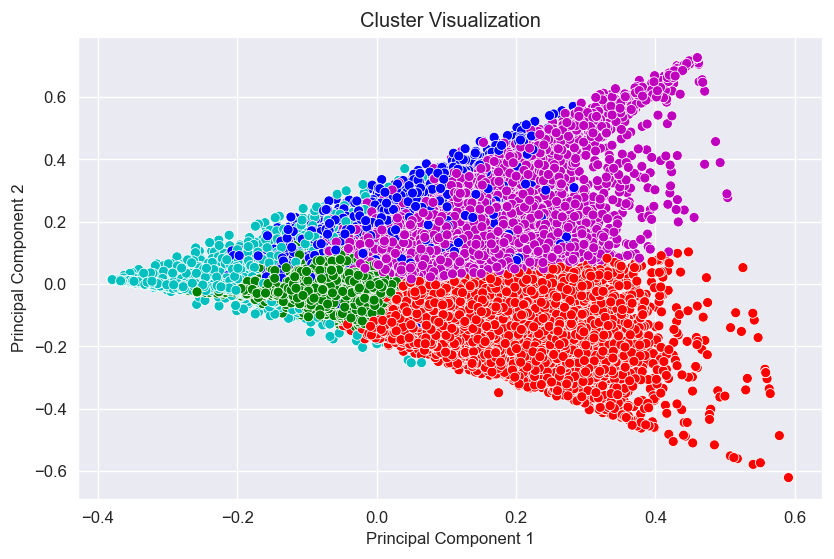

In [16]:
label_color_mapping = {0:'r', 1: 'g', 2: 'b',3:'c' , 4:'m'}
label_color = [label_color_mapping[l] for l in c_preds]

fig, ax = plt.subplots(figsize = (8, 5))
ax = sns.scatterplot(data = temp_df, x = "pc1", y = "pc2", c= label_color)
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_title("Cluster Visualization")
plt.show();

### Top products per cluster

In [17]:
cross_df['cluster'] = c_preds

cluster1 = cross_df[cross_df.cluster == 0]
cluster2 = cross_df[cross_df.cluster == 1]
cluster3 = cross_df[cross_df.cluster == 2]
cluster4 = cross_df[cross_df.cluster == 3]
cluster5 = cross_df[cross_df.cluster == 4]

In [18]:
cluster1.shape

(55852, 135)

In [19]:
cluster2.shape

(99156, 135)

In [20]:
cluster3.shape

(7948, 135)

In [21]:
cluster4.shape

(5417, 135)

In [22]:
cluster5.shape

(37836, 135)

Let's check out what are the top 10 goods bought by people of each cluster. We are going to rely first on the absolute data and then on a percentage among the top 8 products for each cluster.

In [23]:
cluster1.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
fresh vegetables                 37.033660
fresh fruits                     21.751235
packaged vegetables fruits       12.029059
yogurt                            6.161803
packaged cheese                   5.020339
fresh herbs                       4.150147
milk                              4.004512
soy lactosefree                   3.705651
frozen produce                    3.302818
water seltzer sparkling water     3.080248
dtype: float64

In [24]:
cluster2.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
fresh fruits                     9.780417
fresh vegetables                 7.576012
yogurt                           7.227177
packaged vegetables fruits       6.003832
packaged cheese                  4.931986
chips pretzels                   4.482805
milk                             4.255890
water seltzer sparkling water    4.091553
refrigerated                     3.257614
ice cream ice                    3.098683
dtype: float64

In [25]:
cluster3.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
packaged produce                 18.356442
fresh fruits                     10.873427
packaged vegetables fruits        4.242199
fresh vegetables                  3.108455
water seltzer sparkling water     1.714771
milk                              1.614872
packaged cheese                   1.548691
frozen produce                    1.144942
chips pretzels                    1.139280
nuts seeds dried fruit            1.033090
dtype: float64

In [26]:
cluster4.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
water seltzer sparkling water    20.946834
fresh fruits                      3.335979
soft drinks                       2.803397
yogurt                            2.255307
energy granola bars               1.556766
chips pretzels                    1.346686
tea                               1.329887
milk                              1.326749
packaged vegetables fruits        1.251061
soy lactosefree                   1.082518
dtype: float64

In [27]:
cluster5.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
fresh fruits                     35.761127
fresh vegetables                 15.027276
packaged vegetables fruits       12.095782
yogurt                            9.874907
milk                              5.955598
packaged cheese                   5.110900
soy lactosefree                   3.776562
water seltzer sparkling water     3.612829
bread                             3.196004
chips pretzels                    3.128819
dtype: float64

<Axes: xlabel='count', ylabel='cluster'>

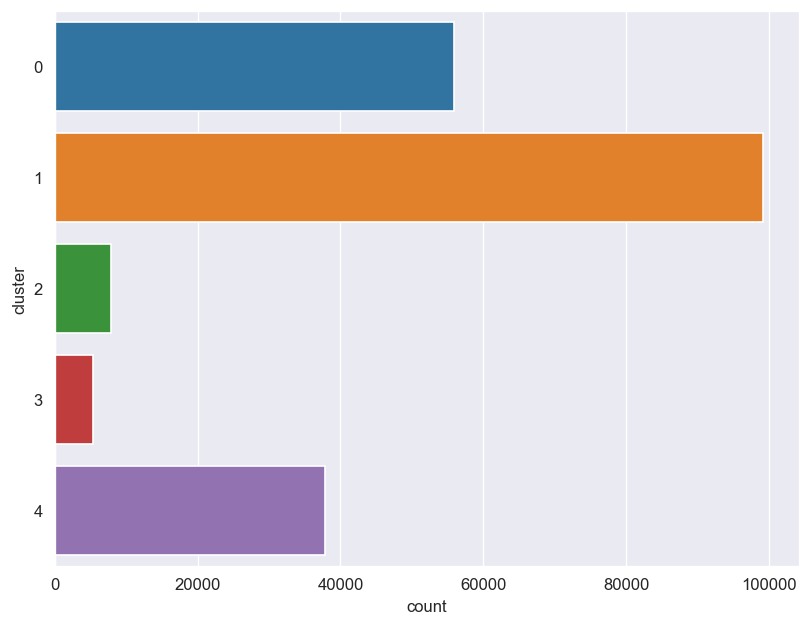

In [28]:
sns.countplot(data= cross_df.reset_index(), y= 'cluster')

#### Customer Segmentation Results:

Cluster 1 results into 55784 consumers who mostly order fresh vegetables followed by fruits.

Cluster 2 results into 99100 consumers who orders products from many aisles. Their mean orders are low compared to other clusters which tells us that either they are not frequent users of Instacart or they are new users and do not have many orders yet.

Cluster 3 results into 7948 consumers who buy packaged produce and fresh fruits mostly.

Cluster 4 results into 5428 consumers having a very strong preference for water seltzer sparkling water aisle.

Cluster 5 results into 37949 consumers who have a very strong preference for fruits followed by fresh vegetables.

